# Initial Modelling V2 - Before Optimization

This notebook represents the "before optimization" stage of the modelling pipeline. Here, we:
- Achieve a working end-to-end model with minimal preprocessing
- Use **no data augmentation** to represent the raw baseline
- Apply **manual hyperparameter tuning** to find reasonable settings
- Evaluate on all fruit types simultaneously (unified model approach)

This serves as a baseline to understand where optimization efforts are needed, which are then addressed in the "Final Modelling v2" notebook.

In [1]:
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

final_data_path = open("step1.txt", "r")
final_data_pre = pd.read_csv(final_data_path.read().strip())

2025-12-21 15:18:08.731612: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
final_data_pre

,id,class_name,file_path,resolution
0,452f2473f3dd5817395dcaa16b58ab6e.png,banana_day1_self,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,720x1280
1,2da7e04b024ef07fd40e4f84213d6ca7.png,banana_day1_self,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,720x1280
2,708f00dd2a7c25d75680d18299d0254d.png,banana_day1_self,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,720x1280
3,866d7784b51be1f26a96af4c99e73448.png,banana_day1_self,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,720x1280
4,2e4fbf3ef0199cd4f664155171dbb849.png,banana_day1_self,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,1280x720
...,...,...,...,...
3850,36d731da560f32647b0b24173553e717.png,banana_unripe_google,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,300x168
3851,8017d535e8953dd8385f2bd274b86048.png,banana_unripe_google,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,225x225
3852,d2db0415723f10fc0543f9661202c5b5.png,banana_unripe_google,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,291x173
3853,dc68cbab2497a85acdab0f2e010085d6.png,banana_unripe_google,/home/fadhlan/Normal2/DeepLearningRepo/steps/v...,225x225


In [2]:
def load_image(filepath, label):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    return img, label

def create_train_test_val_dfs(final_data_pre):
    """
    Create train/test/validation splits with stratification.
    - Validation Set (15%): Held out for final evaluation
    - Training Set (68%): Used to train model weights
    - Testing Set (17%): Used for model evaluation during development
    """
    label_processor = tf.keras.layers.StringLookup(
        output_mode='int', 
        vocabulary=final_data_pre['class_name'].unique(),
        num_oov_indices=0,
        mask_token=None 
    )
    number_of_classes = len(final_data_pre['class_name'].unique())
    train_and_tuning_df, val_df = train_test_split(
        final_data_pre, 
        test_size=0.15, 
        random_state=42, 
        stratify=final_data_pre['class_name']
    )
    train_df, test_df = train_test_split(
        train_and_tuning_df, 
        test_size=0.2, 
        random_state=42, 
        stratify=train_and_tuning_df['class_name']
    )
    print(f"Train (Weights):    {len(train_df)}")
    print(f"Test  (Development):     {len(test_df)}")
    print(f"Val   (Final Eval): {len(val_df)}")
    return {
        "number_of_classes": number_of_classes,
        "label_processor": label_processor,
        "train_df": train_df,
        "test_df": test_df,
        "val_df": val_df
    }

## Data Preparation: Train/Test/Validation Splits

Creating stratified splits to ensure proper model development and unbiased evaluation:
- **Validation Set (15%)**: Held out completely for final evaluation
- **Training Set (68%)**: Used to train model weights
- **Testing Set (17%)**: Used for model evaluation during development

**Note:** No data augmentation is applied in this baseline version.

In [3]:
def create_dses_no_augmentation(input):
    """
    Create TensorFlow datasets WITHOUT data augmentation.
    This represents the baseline 'before optimization' approach.
    """
    def load_image(filepath, label):
        img = tf.io.read_file(filepath)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        return img, label

    def create_dataset(df, is_training=True, batch_size=32):
        # Create source dataset
        ds = tf.data.Dataset.from_tensor_slices((df['file_path'].values, df['class_name'].values))
        ds = ds.map(lambda x, y: (x, input["label_processor"](y)))
        ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training:
            ds = ds.shuffle(buffer_size=1000)
        # Note: No augmentation applied here
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return ds

    # Create the specific datasets
    train_ds = create_dataset(input["train_df"], is_training=True)
    test_ds  = create_dataset(input["test_df"], is_training=False)
    val_ds   = create_dataset(input["val_df"], is_training=False)
    return {
        "train_ds": train_ds,
        "number_of_classes": input["number_of_classes"],
        "test_ds": test_ds,
        "val_ds": val_ds
    }

In [4]:
# Prepare the combined (all fruits) dataset
all_data = final_data_pre
banana_only = final_data_pre[final_data_pre['class_name'].str.contains('banana')]
avocado_only = final_data_pre[final_data_pre['class_name'].str.contains('avocado')]
step1aio = create_train_test_val_dfs(all_data)
step2aio = create_dses_no_augmentation(step1aio)
step1banana = create_train_test_val_dfs(banana_only)
step2banana = create_dses_no_augmentation(step1banana)
step1avocado = create_train_test_val_dfs(avocado_only)
step2avocado = create_dses_no_augmentation(step1avocado)

I0000 00:00:1766330298.103412   90347 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6136 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Train (Weights):    2620
Test  (Development):     656
Val   (Final Eval): 579
Train (Weights):    252
Test  (Development):     64
Val   (Final Eval): 56
Train (Weights):    2368
Test  (Development):     592
Val   (Final Eval): 523


## Create Datasets

Creating TensorFlow datasets from the prepared data splits. Note that **no data augmentation** is applied here—we're using raw images to establish a baseline.

## Manual Model Architecture and Training

Instead of using Optuna for hyperparameter optimization, we manually select hyperparameters for this baseline model. This represents the "rough draft" stage where we're establishing a working pipeline before optimization.

In [5]:
%run modeldef4.py

# --- Manually Selected Hyperparameters (Baseline) ---
manual_lr = 1e-4  # Learning rate
manual_dropout = 0.3  # Dropout rate
manual_epochs = 5  # Number of epochs
manual_layer_configs = [128, 64]  # Two layers with 256 and 128 units

# Build the model with manual hyperparameters
def build_baseline_model(num_classes):
    baseline_model = DynamicResNetClassifier(
        num_classes=num_classes,
        layer_configs=manual_layer_configs,
        dropout_rate=manual_dropout
    )

    # Compile the model
    baseline_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=manual_lr),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    baseline_model.build(input_shape=(None, 224, 224, 3))
    return baseline_model
baseline_model_aio = build_baseline_model(step2aio["number_of_classes"])
baseline_model_banana = build_baseline_model(step2banana["number_of_classes"])
baseline_model_avocado = build_baseline_model(step2avocado["number_of_classes"])


print("="*50)
print("BASELINE MODEL CONFIGURATION")
print("="*50)
print(f"Learning Rate: {manual_lr}")
print(f"Dropout Rate: {manual_dropout}")
print(f"Epochs: {manual_epochs}")
print(f"Layer Configuration: {manual_layer_configs}")
print("="*50)

/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dynamic_res_net_classifier', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dynamic_res_net_classifier_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


BASELINE MODEL CONFIGURATION
Learning Rate: 0.0001
Dropout Rate: 0.3
Epochs: 5
Layer Configuration: [128, 64]


/root/miniconda3/envs/DeepLearning/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'dynamic_res_net_classifier_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


## Training the Baseline Model

Training with manually selected hyperparameters on the combined dataset (all fruit types).

In [6]:
print("\nStarting Baseline Model Training...")
history_aio = baseline_model_aio.fit(
    step2aio["train_ds"],
    validation_data=step2aio["test_ds"],
    epochs=manual_epochs,
    verbose=1
)
history_banana = baseline_model_banana.fit(
    step2banana["train_ds"],
    validation_data=step2banana["test_ds"],
    epochs=manual_epochs,
    verbose=1
)
history_avocado = baseline_model_avocado.fit(
    step2avocado["train_ds"],
    validation_data=step2avocado["test_ds"],
    epochs=manual_epochs,
    verbose=1
)


Starting Baseline Model Training...
Epoch 1/5


2025-12-21 15:18:37.033817: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f69b0002b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-21 15:18:37.033837: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-12-21 15:18:37.174985: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-21 15:18:38.339908: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
2025-12-21 15:18:38.557077: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 15:18:38.557157: I e

 3/82 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.1233 - loss: 3.1519 

I0000 00:00:1766330324.908891   91513 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2243 - loss: 2.5273

2025-12-21 15:18:50.609315: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 15:18:51.527651: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5599', 24 bytes spill stores, 24 bytes spill loads

2025-12-21 15:18:51.625166: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5599', 28 bytes spill stores, 28 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2255 - loss: 2.5228

2025-12-21 15:18:57.080112: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 15:18:57.774893: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1733', 100 bytes spill stores, 100 bytes spill loads



82/82 ━━━━━━━━━━━━━━━━━━━━ 31s 221ms/step - accuracy: 0.3275 - loss: 2.1583 - val_accuracy: 0.6357 - val_loss: 1.3829
Epoch 2/5
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.5244 - loss: 1.4969 - val_accuracy: 0.7561 - val_loss: 0.9445
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6447 - loss: 1.1278 - val_accuracy: 0.8323 - val_loss: 0.7208
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7210 - loss: 0.9048 - val_accuracy: 0.8659 - val_loss: 0.5716
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 68ms/step - accuracy: 0.7710 - loss: 0.7291 - val_accuracy: 0.8643 - val_loss: 0.4479
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.1151 - loss: 2.7209 - val_accuracy: 0.1562 - val_loss: 2.1204
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.1548 - loss: 2.3575 - val_accuracy: 0.2188 - val_loss: 1.9702
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.2222 - loss: 2.0382 - val_accuracy: 0.2344 - val_loss: 1.87

In [8]:
def visualize_predictions(dataset, model, label_processor, grid_rows=2, grid_cols=4):
    """
    Visualize correct and incorrect predictions in grid format.
    """
    num_samples = grid_rows * grid_cols
    class_names = label_processor.get_vocabulary()
    correct_batch = {'imgs': [], 'true': [], 'pred': []}
    incorrect_batch = {'imgs': [], 'true': [], 'pred': []}

    print(f"Collecting {num_samples} correct and {num_samples} incorrect examples...")
    
    for images, labels in dataset:
        if (len(correct_batch['imgs']) >= num_samples and 
            len(incorrect_batch['imgs']) >= num_samples):
            break

        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)
        
        images_np = images.numpy()
        labels_np = labels.numpy()
        preds_np = preds.numpy()
        
        for i in range(len(images_np)):
            if (len(correct_batch['imgs']) >= num_samples and 
                len(incorrect_batch['imgs']) >= num_samples):
                break
            
            true_idx = labels_np[i]
            pred_idx = preds_np[i]
            is_correct = (true_idx == pred_idx)
            
            target_dict = correct_batch if is_correct else incorrect_batch
            
            if len(target_dict['imgs']) < num_samples:
                target_dict['imgs'].append(images_np[i])
                target_dict['true'].append(class_names[true_idx])
                target_dict['pred'].append(class_names[pred_idx])

    # Plot helper function
    def plot_grid(data_dict, title, color_code):
        count = len(data_dict['imgs'])
        if count == 0:
            print(f"No {title.lower()} predictions found.")
            return
        
        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(3 * grid_cols, 3.5 * grid_rows))
        fig.suptitle(f"{title} Predictions", fontsize=20, color=color_code, weight='bold', y=1.02)
        axes_flat = axes.flatten() if count > 1 else [axes]
        
        for i in range(num_samples):
            ax = axes_flat[i]
            
            if i >= count:
                ax.axis('off')
                continue
            
            img = data_dict['imgs'][i].astype("uint8")
            ax.imshow(img)
            ax.axis("off")
            true_lab = data_dict['true'][i]
            pred_lab = data_dict['pred'][i]
            label_text = f"True: {true_lab}\nPred: {pred_lab}"
            ax.set_title(label_text, color='black', fontsize=11, pad=10)
            border_color = color_code
            plt.setp(ax.spines.values(), color=border_color, linewidth=2)

        plt.tight_layout()
        plt.show()

    plot_grid(correct_batch, "Correct", "green")
    print("\n" + "="*50 + "\n")
    plot_grid(incorrect_batch, "Incorrect", "red")

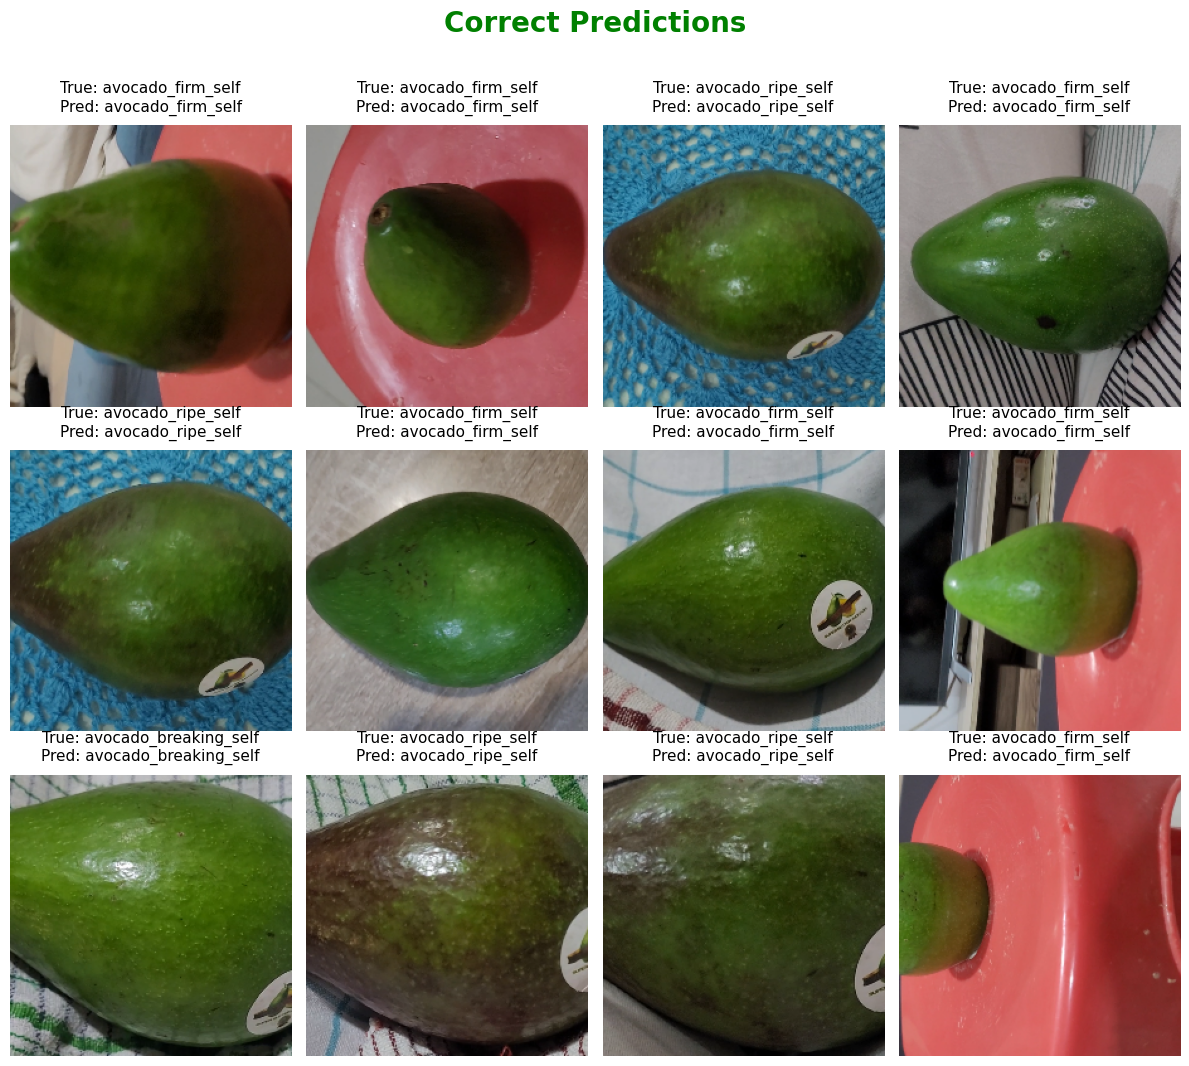

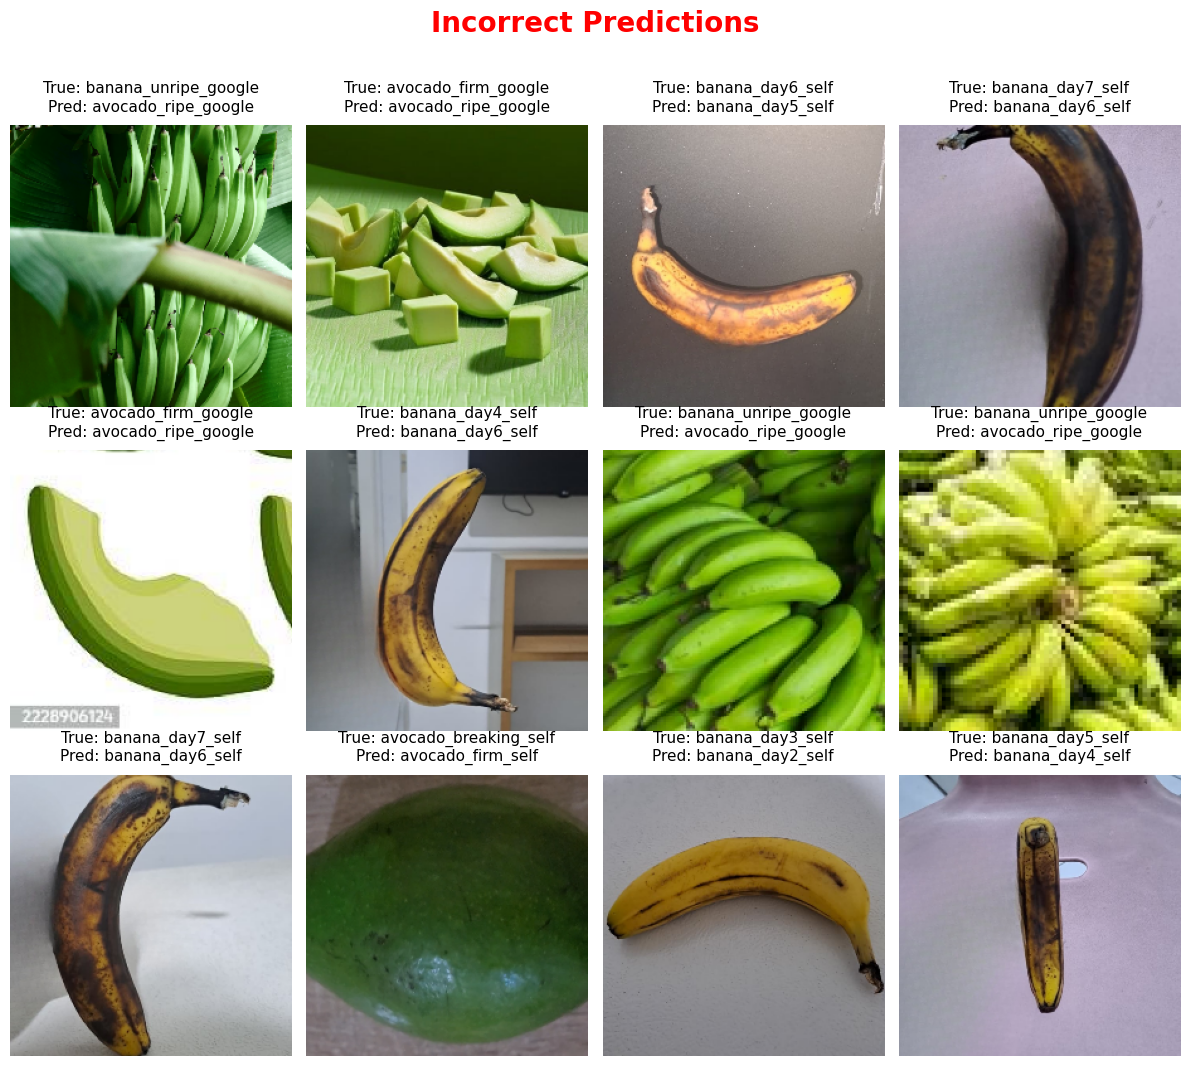

In [19]:
visualize_predictions(
    step2["val_ds"],
    baseline_model,
    step1["label_processor"],
    grid_rows=3,
    grid_cols=4
)

## Qualitative Analysis: Visualization of Predictions

Examining what the model predicts correctly and incorrectly helps us understand failure modes and identify areas where optimization efforts (like augmentation and hyperparameter tuning) might help.

In [8]:
print("\nRunning Final Evaluation on Hold-out Set (val_ds)...")
test_loss, test_accuracy = baseline_model_aio.evaluate(step2aio["val_ds"])
print(f"BASELINE MODEL FINAL ACCURACY for AIO: {test_accuracy * 100:.2f}%")
print(f"BASELINE MODEL FINAL LOSS for AIO: {test_loss:.4f}")
print("\nObservations:")
print("- This baseline model achieves initial working accuracy")
print("- Compare with Final Modelling v2 to see impact of optimization")
print("- Key areas for improvement:")
print("  1. Data augmentation to improve generalization")
print("  2. Hyperparameter tuning with Optuna")
print("  3. Better architectural choices")


Running Final Evaluation on Hold-out Set (val_ds)...
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.8670 - loss: 0.4532
BASELINE MODEL FINAL ACCURACY for AIO: 86.70%
BASELINE MODEL FINAL LOSS for AIO: 0.4532

Observations:
- This baseline model achieves initial working accuracy
- Compare with Final Modelling v2 to see impact of optimization
- Key areas for improvement:
  1. Data augmentation to improve generalization
  2. Hyperparameter tuning with Optuna
  3. Better architectural choices


In [9]:
print("\nRunning Final Evaluation on Hold-out Set (val_ds)...")
test_loss, test_accuracy = baseline_model_avocado.evaluate(step2avocado["val_ds"])
print(f"BASELINE MODEL FINAL ACCURACY for Avocado: {test_accuracy * 100:.2f}%")
print(f"BASELINE MODEL FINAL LOSS for Avocado: {test_loss:.4f}")
print("\nObservations:")
print("- This baseline model achieves initial working accuracy")
print("- Compare with Final Modelling v2 to see impact of optimization")
print("- Key areas for improvement:")
print("  1. Data augmentation to improve generalization")
print("  2. Hyperparameter tuning with Optuna")
print("  3. Better architectural choices")


Running Final Evaluation on Hold-out Set (val_ds)...
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step - accuracy: 0.9560 - loss: 0.1702
BASELINE MODEL FINAL ACCURACY for Avocado: 95.60%
BASELINE MODEL FINAL LOSS for Avocado: 0.1702

Observations:
- This baseline model achieves initial working accuracy
- Compare with Final Modelling v2 to see impact of optimization
- Key areas for improvement:
  1. Data augmentation to improve generalization
  2. Hyperparameter tuning with Optuna
  3. Better architectural choices


In [10]:
print("\nRunning Final Evaluation on Hold-out Set (val_ds)...")
test_loss, test_accuracy = baseline_model_banana.evaluate(step2banana["val_ds"])
print(f"BASELINE MODEL FINAL ACCURACY for Banana: {test_accuracy * 100:.2f}%")
print(f"BASELINE MODEL FINAL LOSS for Banana: {test_loss:.4f}")
print("\nObservations:")
print("- This baseline model achieves initial working accuracy")
print("- Compare with Final Modelling v2 to see impact of optimization")
print("- Key areas for improvement:")
print("  1. Data augmentation to improve generalization")
print("  2. Hyperparameter tuning with Optuna")
print("  3. Better architectural choices")


Running Final Evaluation on Hold-out Set (val_ds)...
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4375 - loss: 1.5629

2025-12-21 15:23:07.020976: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-21 15:23:07.846714: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1733', 292 bytes spill stores, 292 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.4107 - loss: 1.6392  
BASELINE MODEL FINAL ACCURACY for Banana: 41.07%
BASELINE MODEL FINAL LOSS for Banana: 1.6392

Observations:
- This baseline model achieves initial working accuracy
- Compare with Final Modelling v2 to see impact of optimization
- Key areas for improvement:
  1. Data augmentation to improve generalization
  2. Hyperparameter tuning with Optuna
  3. Better architectural choices


## Final Evaluation on Hold-out Validation Set

This is the critical evaluation step. We evaluate the trained model on the validation set, which was never touched during training or development. This gives us an unbiased estimate of real-world performance.

## Comparative Analysis: Specialized vs. Unified Models

This section mirrors the quantitative analysis from "Final Modelling v2" to compare specialized models (avocado-only, banana-only) against the unified all-in-one model on their respective validation subsets.

Prerequisites:
- Ensure `all_in_one_model.keras` exists (from Final Modelling v2). If unavailable, this uses `baseline_model` as a fallback for the combined model.
- Optionally provide paths to specialized Keras models for avocado and banana to enable full comparison.

Notes:
- Label processors differ between combined vs specialized models; this section constructs appropriate datasets for each.
- No data augmentation is applied here (consistent with this notebook's baseline).

In [13]:
# Setup models and subsets for quantitative comparison
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support

# --- Helper Function for Detailed Metrics ---
def evaluate_model_on_subset(model_name, model, dataset):
    y_true_vals = []
    y_pred_vals = []
    
    # Iterate through the dataset to get predictions
    for images, labels in dataset:
        logits = model(images, training=False)
        preds = tf.argmax(logits, axis=1)
        y_true_vals.extend(labels.numpy())
        y_pred_vals.extend(preds.numpy())
    
    # Calculate Metrics (Macro average)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_vals, y_pred_vals, average='macro', zero_division=0
    )
    
    # Calculate simple accuracy for reference
    accuracy = np.mean(np.array(y_true_vals) == np.array(y_pred_vals))
    
    print(f"  {model_name}:")
    print(f"    Accuracy : {accuracy*100:.2f}%")
    print(f"    F1-Score : {f1:.4f}")
    print(f"    Precision: {precision:.4f}")
    print(f"    Recall   : {recall:.4f}")
# ---------------------------------------------

# Try to load the combined (all-in-one) model; fall back to baseline_model if missing
combined_model = None
try:
    combined_model = tf.keras.models.load_model("all_in_one_model.keras")
    print("Loaded combined model from all_in_one_model.keras")
except Exception as e:
    combined_model = baseline_model_aio
    print("Warning: all_in_one_model.keras not found; using baseline_model as combined model.")

# Optional: provide specialized model paths to enable full comparison
avocado_model = baseline_model_avocado
banana_model = baseline_model_banana

# Build validation subsets for avocado and banana using the combined split (step1)
avocado_val_df = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("avocado")]
banana_val_df  = step1aio["val_df"][step1aio["val_df"]["class_name"].str.contains("banana")]

# Combined model evaluation datasets mapped with combined label processor
aio_val_avocado = (
    tf.data.Dataset.from_tensor_slices((avocado_val_df["file_path"].values, avocado_val_df["class_name"].values))
    .map(lambda x, y: (x, step1aio["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
 )
aio_val_banana = (
    tf.data.Dataset.from_tensor_slices((banana_val_df["file_path"].values, banana_val_df["class_name"].values))
    .map(lambda x, y: (x, step1aio["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
 )

# Construct specialized label processors/datasets (avocado-only, banana-only)
avocado_only_df = final_data_pre[final_data_pre["class_name"].str.contains("avocado")]
banana_only_df  = final_data_pre[final_data_pre["class_name"].str.contains("banana")]
step1_avc = create_train_test_val_dfs(avocado_only_df)
step1_ban = create_train_test_val_dfs(banana_only_df)

avc_val_avocado = (
    tf.data.Dataset.from_tensor_slices((step1_avc["val_df"]["file_path"].values, step1_avc["val_df"]["class_name"].values))
    .map(lambda x, y: (x, step1_avc["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
 )
ban_val_banana = (
    tf.data.Dataset.from_tensor_slices((step1_ban["val_df"]["file_path"].values, step1_ban["val_df"]["class_name"].values))
    .map(lambda x, y: (x, step1_ban["label_processor"](y)))
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32).prefetch(tf.data.AUTOTUNE)
 )

# Evaluate and print quantitative comparison
print("SUBSPACE EVALUATION: AVOCADO SUBSET")
evaluate_model_on_subset("Combined Model", combined_model, aio_val_avocado)

if avocado_model is not None:
    evaluate_model_on_subset("Avocado-only Model", avocado_model, avc_val_avocado)
else:
    print("  Avocado-only  : (set AVOCADO_MODEL_PATH to evaluate)")

print("SUBSPACE EVALUATION: BANANA SUBSET")
evaluate_model_on_subset("Combined Model", combined_model, aio_val_banana)

if banana_model is not None:
    evaluate_model_on_subset("Banana-only Model", banana_model, ban_val_banana)
else:
    print("  Banana-only   : (set BANANA_MODEL_PATH to evaluate)")

Train (Weights):    2368
Test  (Development):     592
Val   (Final Eval): 523
Train (Weights):    252
Test  (Development):     64
Val   (Final Eval): 56
SUBSPACE EVALUATION: AVOCADO SUBSET
  Combined Model:
    Accuracy : 92.35%
    F1-Score : 0.6164
    Precision: 0.6461
    Recall   : 0.6054
  Avocado-only Model:
    Accuracy : 95.60%
    F1-Score : 0.8059
    Precision: 0.8461
    Recall   : 0.7799
SUBSPACE EVALUATION: BANANA SUBSET
  Combined Model:
    Accuracy : 33.93%
    F1-Score : 0.2469
    Precision: 0.2831
    Recall   : 0.2460
  Banana-only Model:
    Accuracy : 41.07%
    F1-Score : 0.4109
    Precision: 0.4535
    Recall   : 0.4087


2025-12-21 15:26:19.139057: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Quantitative Comparison: Interpretation Guide

- If specialized models significantly outperform the combined model (e.g., >5% difference), consider separate models.
- If performance is similar, prefer the combined model for simpler deployment.
- Minor differences can be noise; multiple random seeds improve robustness.

Operational implications:
- Deployment simplicity with one model vs. separate pipelines.
- Potential cross-fruit knowledge sharing in unified models.
- Balance slight accuracy trade-offs with maintenance overhead.

## Kesimpulan Akhir (Initial Modelling v2 — Before Optimization)
### Hasil Utama (Baseline)

Evaluasi pada *hold-out validation set* menghasilkan **akurasi sebesar 86.70%** dengan **loss sebesar 0.4532**. Namun, ketika performa dianalisis lebih lanjut berdasarkan subset buah, terlihat adanya perbedaan yang signifikan:
- **Subset Avocado**:  
  Model gabungan (*combined*) mencapai akurasi **92.35%**, sedangkan model khusus avocado (*avocado-only*) mencapai **95.60%**.
- **Subset Banana**:  
  Model gabungan hanya mencapai akurasi **33.93%**, sementara model khusus banana (*banana-only*) mencapai **41.07%**.

### Analisis Permasalahan

1. **Baseline model menunjukkan bias mayoritas yang kuat.** Meskipun akurasi keseluruhan terlihat tinggi (86.70%), angka ini menipu karena didominasi oleh kelas mayoritas (avocado). Evaluasi per-subset membuktikan ketimpangan performa yang ekstrim: model sangat mahir mengenali avocado (92.35%) namun gagal mengenali pisang (33.93%).

2. **Model spesialis secara konsisten mengungguli model gabungan.** Pemisahan domain terbukti efektif bahkan pada tahap baseline. Model *avocado-only* (95.60%) mengungguli performa subset avocado pada model gabungan (92.35%). Demikian pula, model *banana-only* (41.07%) mampu bekerja lebih baik daripada saat digabungkan (33.93%), meskipun performanya masih jauh dari optimal.

3. **Loss yang tinggi pada Banana mengindikasikan konvergensi yang buruk.** Perbedaan nilai loss sangat mencolok: *avocado-only* memiliki loss rendah (**0.1702**), sedangkan *banana-only* memiliki loss yang sangat tinggi (**1.6392**). Hal ini menunjukkan bahwa tanpa optimasi hyperparameter (seperti learning rate yang adaptif), model gagal menemukan *global minima* untuk fitur visual pisang yang lebih kompleks.

4. **Ketiadaan data augmentation membatasi generalisasi.** Rendahnya akurasi pada banana (baik 33.93% di combined maupun 41.07% di specialized) mengindikasikan bahwa model baseline mengalami *overfitting* atau kesulitan membedakan variasi visual yang halus (seperti perubahan gradasi warna hijau ke kuning) tanpa bantuan augmentasi data dan tuning yang tepat.